In [2]:
#!pip install tensorflow

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from skimage.util import montage
from sklearn.decomposition import PCA
import matplotlib.patheffects as path_effects
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D

c:\Users\Rodrigo\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [134]:
# @title Download the data

import os, requests, tarfile

fnames = ["kay_labels.npy", "kay_labels_val.npy", "kay_images.npz"]
urls = ["https://osf.io/r638s/download",
        "https://osf.io/yqb3e/download",
        "https://osf.io/ymnjv/download"]

for fname, url in zip(fnames, urls):
  if not os.path.isfile(fname):
    try:
      r = requests.get(url)
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        print(f"Downloading {fname}...")
        with open(fname, "wb") as fid:
          fid.write(r.content)
        print(f"Download {fname} completed!")

In [135]:
with np.load(fname) as dobj:
  dat = dict(**dobj)
labels = np.load('kay_labels.npy')
val_labels = np.load('kay_labels_val.npy')


print(f'Stimuli shape: {dat["stimuli"].shape}')
print(f'Response shape: {dat["responses"].shape}')
print(f'Labels shape: {labels.shape}, {val_labels.shape}')

Stimuli shape: (1750, 128, 128)
Response shape: (1750, 8428)
Labels shape: (4, 1750), (4, 120)



`labels` is a 4 by stim array of class names:  
- row 3 has the labels predicted by a deep neural network (DNN) trained on Imagenet
- rows 0-2 correspond to different levels of the wordnet hierarchy for the DNN predictions

In [36]:
labels[:3,:]

array([['artifact', 'entity', 'animal', ..., 'artifact', 'artifact',
        'artifact'],
       ['instrumentality', 'round shape', 'vertebrate', ..., 'structure',
        'structure', 'instrumentality'],
       ['equipment', 'sphere', 'mammal', ..., 'building', 'landing',
        'conveyance']], dtype='<U71')

In [6]:
print(labels[:, :4])
print(dat.keys())

[['artifact' 'entity' 'animal' 'animal']
 ['instrumentality' 'round shape' 'vertebrate' 'vertebrate']
 ['equipment' 'sphere' 'mammal' 'amphibian']
 ['croquet ball' 'bubble' 'komondor' 'tailed frog']]
dict_keys(['stimuli', 'stimuli_test', 'responses', 'responses_test', 'roi', 'roi_names'])


`dat` has the following fields:  
- `stimuli`: stim x i x j array of grayscale stimulus images
- `stimuli_test`: stim x i x j array of grayscale stimulus images in the test set  
- `responses`: stim x voxel array of z-scored BOLD response amplitude
- `responses_test`:  stim x voxel array of z-scored BOLD response amplitude in the test set  
- `roi`: array of voxel labels
- `roi_names`: array of names corresponding to voxel labels

This is the number of voxels in each ROI. Note that `"Other"` voxels have been removed from this version of the dataset:

In [7]:
dict(zip(dat["roi_names"], np.bincount(dat["roi"])))

{'Other': 0,
 'V1': 1294,
 'V2': 2083,
 'V3': 1790,
 'V3A': 484,
 'V3B': 314,
 'V4': 1535,
 'LatOcc': 928}

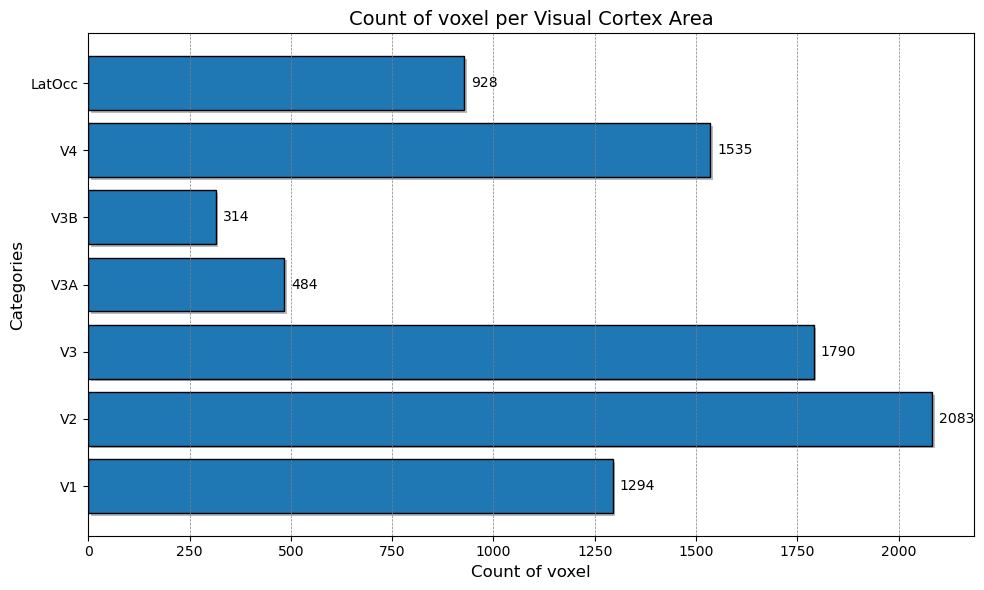

In [8]:
ddd = dict(zip(dat["roi_names"], np.bincount(dat["roi"])))

values = list(ddd.values())[1:]
names = list(ddd.keys())[1:]

# Create a horizontal bar plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(names, values, edgecolor='black')

# Add grid lines
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', axis='x')

# Add value annotations to each bar
for bar in bars:
    width = bar.get_width()
    ax.annotate(f'{width}', xy=(width, bar.get_y() + bar.get_height() / 2),
                xytext=(5, 0), textcoords="offset points",
                ha='left', va='center', fontsize=10, color='black')

# Customize title and labels
plt.xlabel('Count of voxel', fontsize=12)
plt.ylabel('Categories', fontsize=12)
plt.title('Count of voxel per Visual Cortex Area', fontsize=14)

# Customize ticks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add shadow effect to the bars
for bar in bars:
    bar.set_path_effects([plt.matplotlib.patheffects.withSimplePatchShadow()])

# Adjust the layout and spacing
plt.tight_layout()

# Show the plot
plt.show()

Each stimulus is a 128 x 128 grayscale array:

C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_2384\3506099172.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


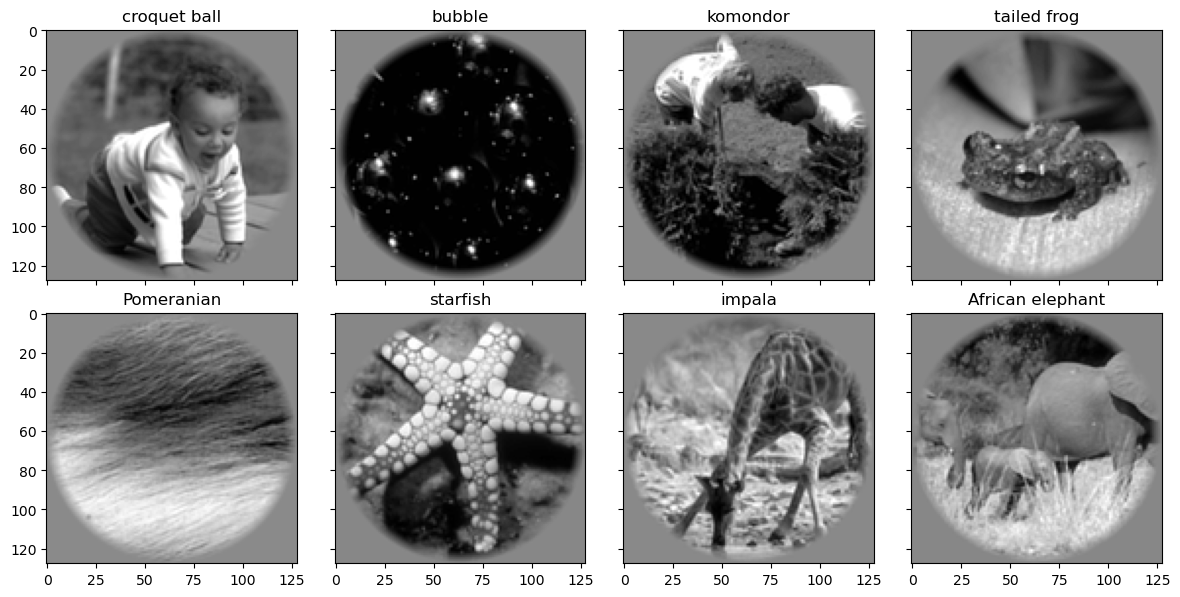

In [9]:
fig, axs = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
for ax, im, lbl in zip(axs.flat, dat["stimuli"], labels[-1, :]):
  ax.imshow(im, cmap="gray")
  ax.set_title(lbl)
fig.tight_layout()
fig.show()

Each stimulus is associated with a pattern of BOLD response across voxels in visual cortex:

C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_2384\2625672689.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


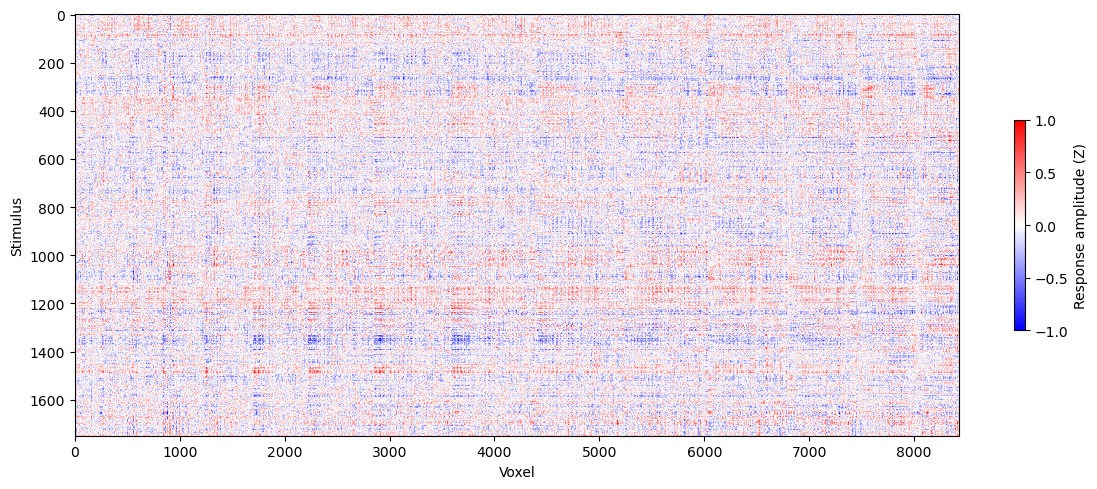

In [10]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.set(xlabel="Voxel", ylabel="Stimulus")
heatmap = ax.imshow(dat["responses"],
                    aspect="auto", vmin=-1, vmax=1, cmap="bwr")
fig.colorbar(heatmap, shrink=.5, label="Response amplitude (Z)")
fig.tight_layout()
fig.show()

The training/validation splits from the original paper are retained, so the 120 test stimuli and responses are in separate data structures:

C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_2384\570546184.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


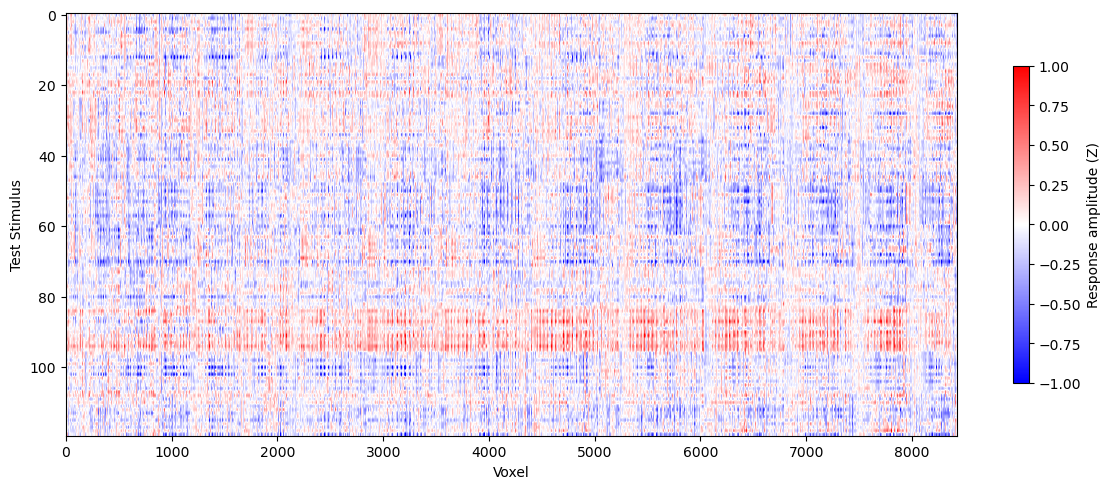

In [11]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.set(xlabel="Voxel", ylabel="Test Stimulus")
heatmap = ax.imshow(dat["responses_test"],
                    aspect="auto", vmin=-1, vmax=1, cmap="bwr")
fig.colorbar(heatmap, shrink=.75, label="Response amplitude (Z)")
fig.tight_layout()
fig.show()

In [7]:
dat['stimuli'].shape


(1750, 128, 128)

In [9]:
dat['responses'].shape

(1750, 8428)

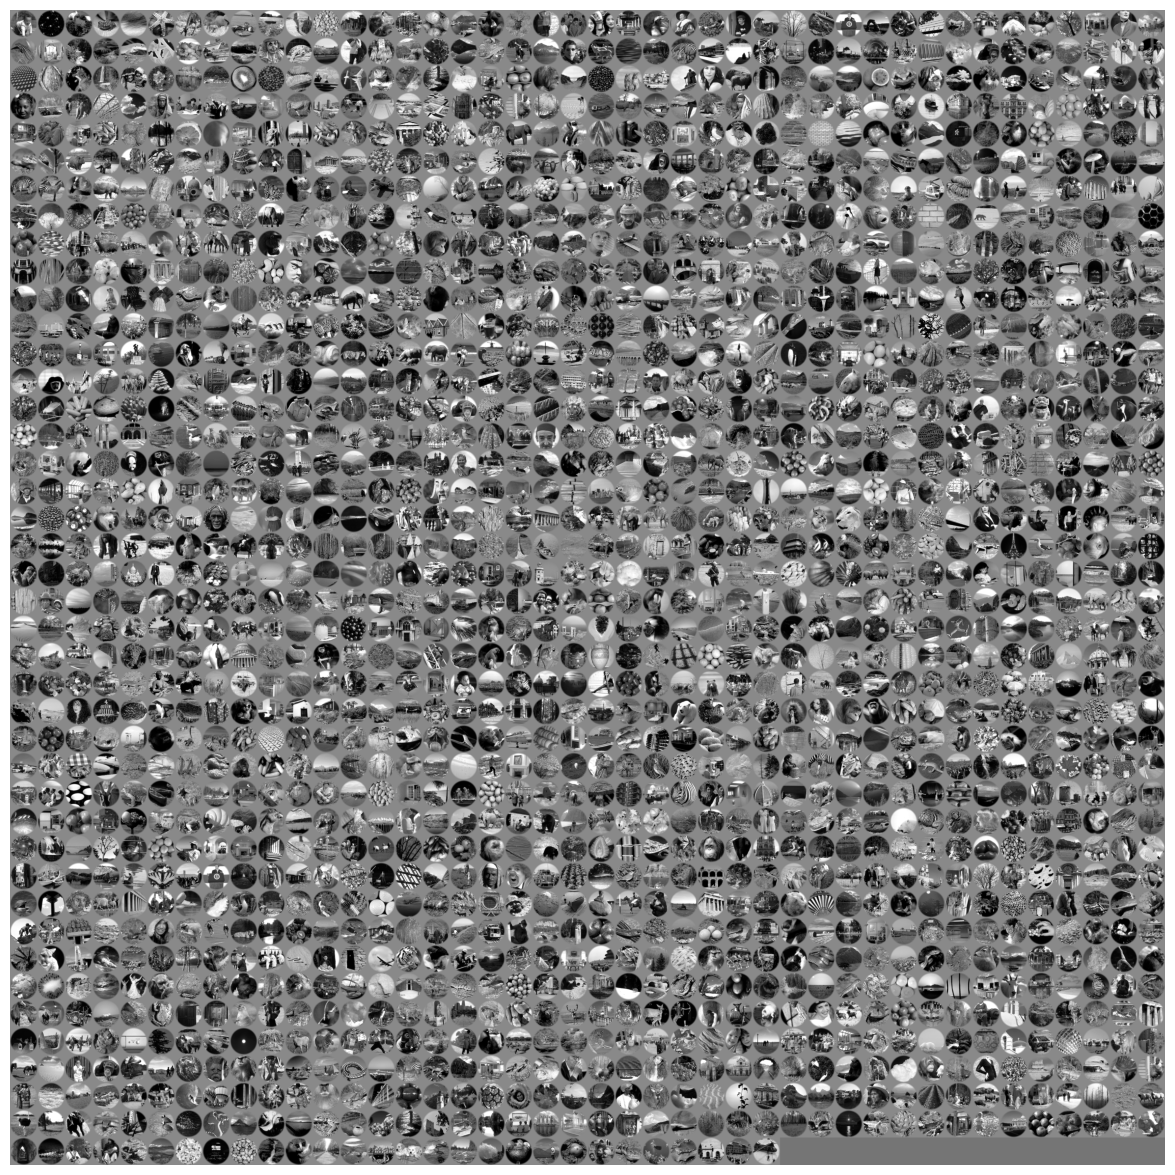

In [12]:
out = montage(dat['stimuli'])
f, ax = plt.subplots(figsize = (15,15))
plt.imshow(out, cmap = 'gray'); plt.axis('off');

In [13]:
flat_dat = np.reshape(dat['stimuli'], (dat['stimuli'].shape[0],-1))

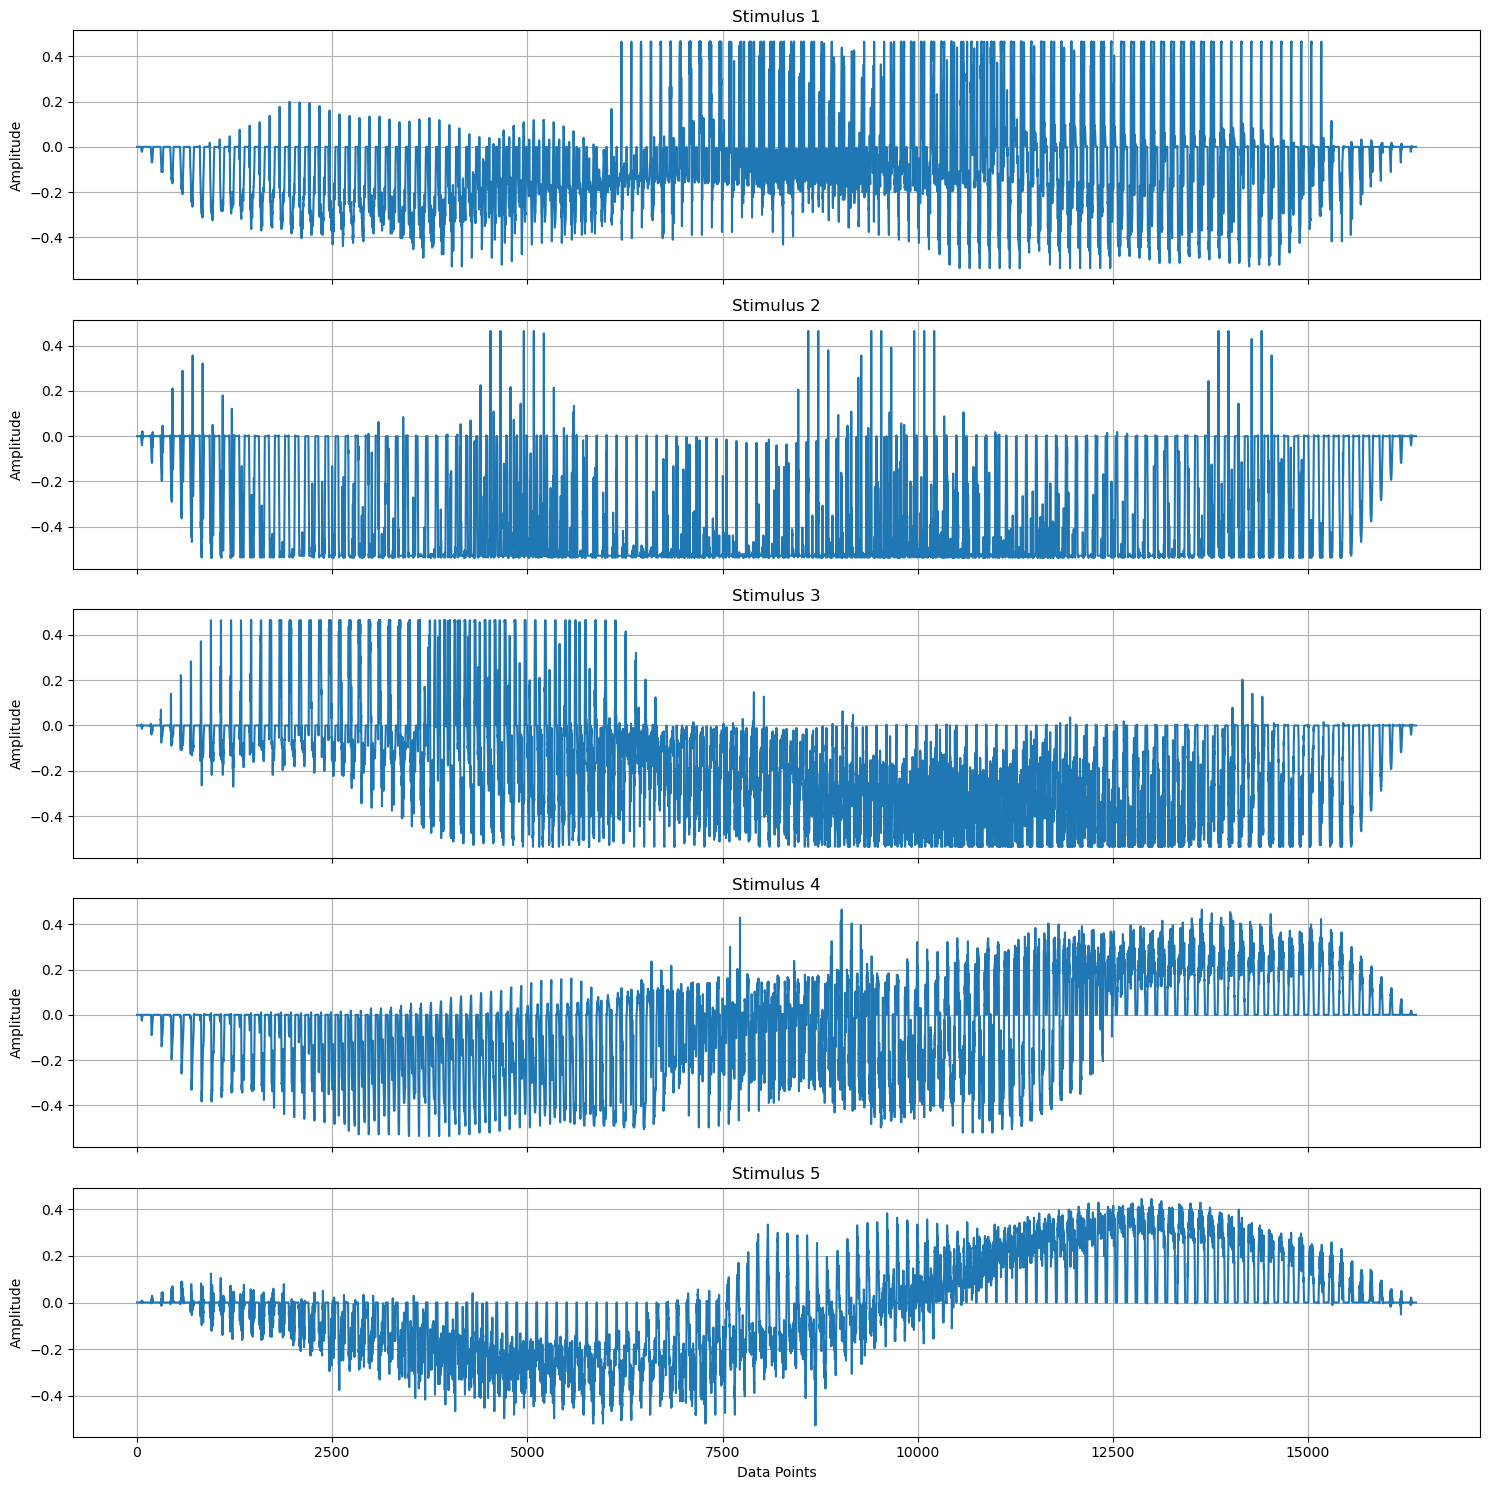

In [14]:
# Create 10 subplots for the first 10 stimuli in the data array
fig, axes = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

for i in range(5):
    axes[i].plot(flat_dat[i])
    axes[i].set_title(f'Stimulus {i+1}')
    axes[i].set_ylabel('Amplitude')
    axes[i].grid(True)

plt.xlabel('Data Points')
plt.tight_layout()
plt.show()

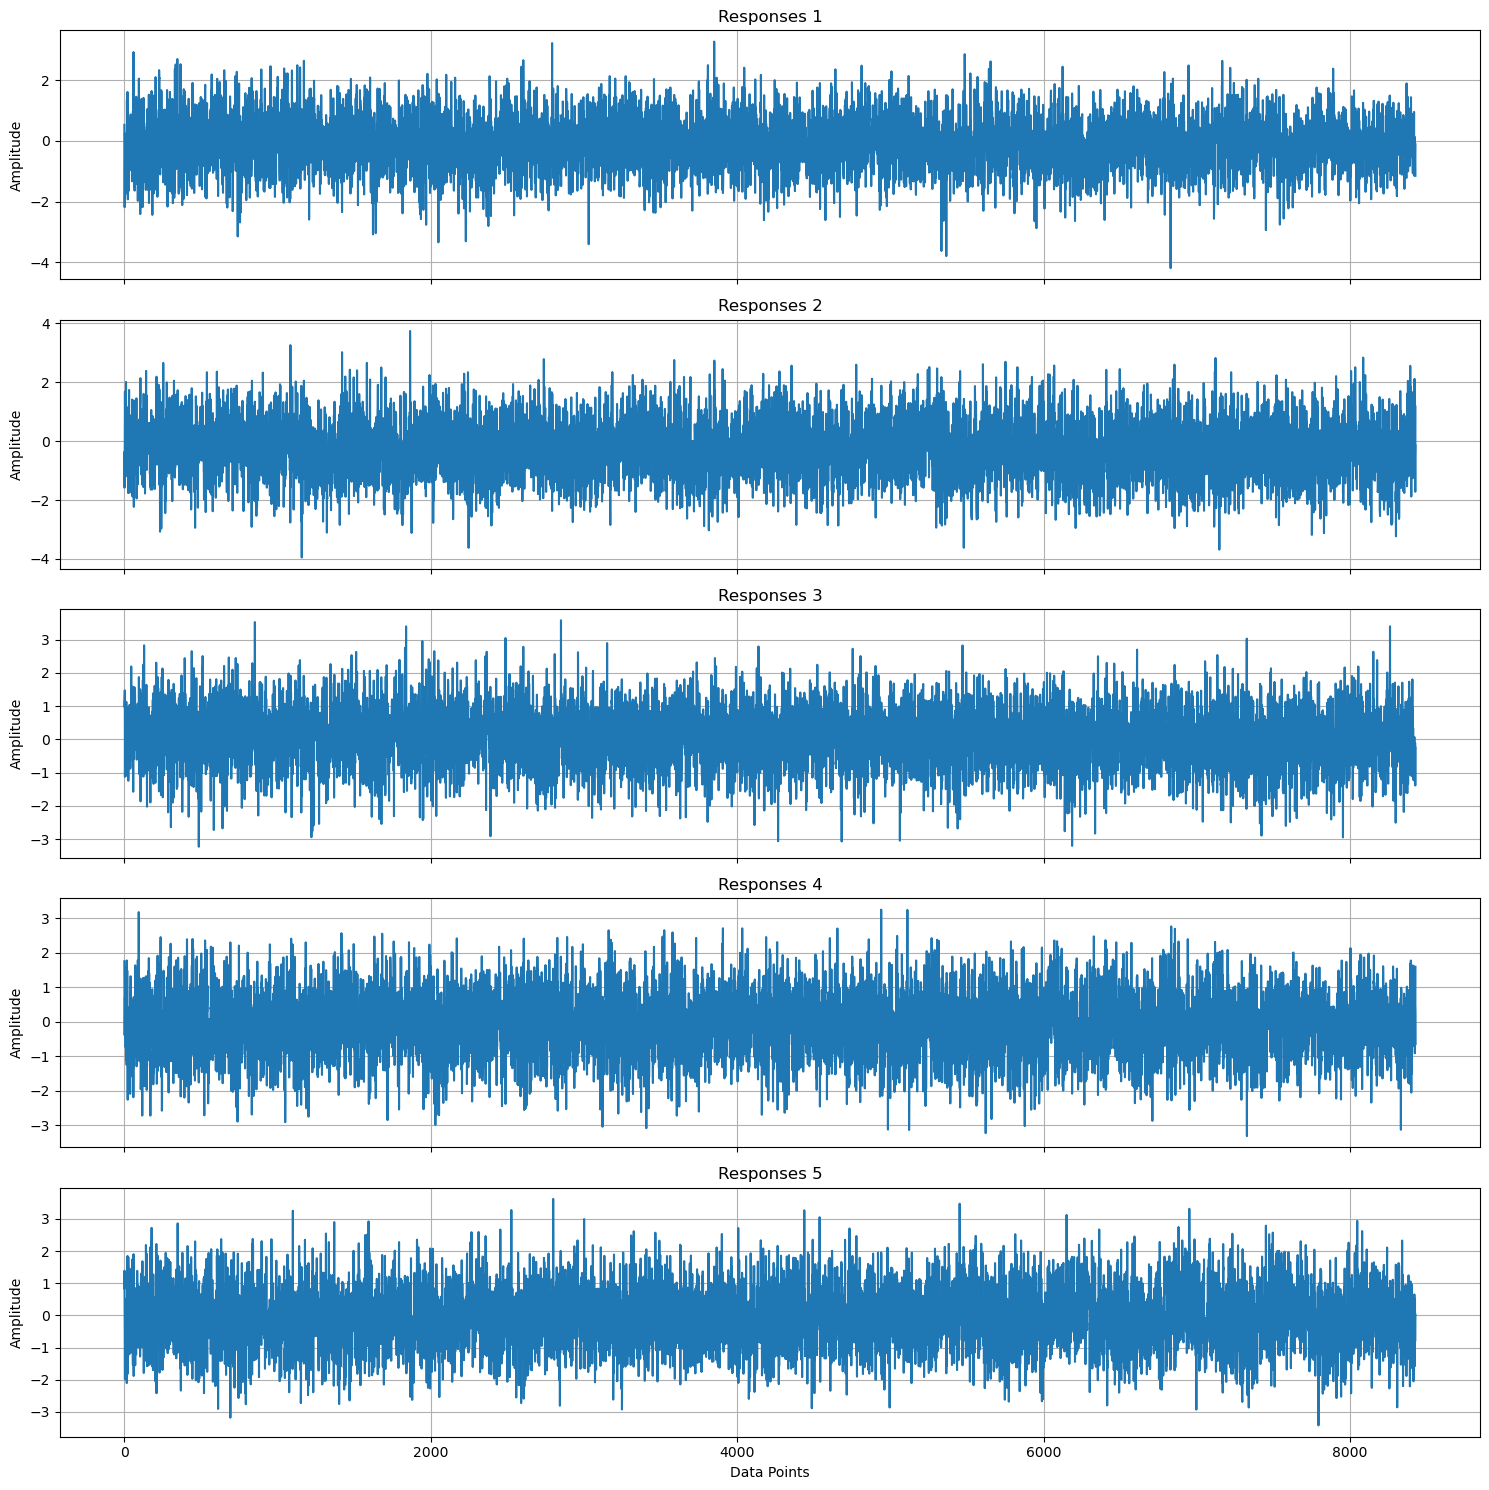

In [15]:
# Create 10 subplots for the first 10 stimuli in the data array
fig, axes = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

for i in range(5):
    axes[i].plot(dat['responses'][i])
    axes[i].set_title(f'Responses {i+1}')
    axes[i].set_ylabel('Amplitude')
    axes[i].grid(True)

plt.xlabel('Data Points')
plt.tight_layout()
plt.show()

In [30]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, Reshape, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

from sklearn.decomposition import PCA


In [31]:
scaler = StandardScaler()
brain_wave_responses_scaled = scaler.fit_transform(dat['responses'])
pca = PCA(n_components=128)
brain_wave_responses_reduced = pca.fit_transform(brain_wave_responses_scaled)

In [16]:
responses = dat['responses']
stimuli = dat['stimuli']
stimuli = stimuli/255.0 # normalize

stimuli_flat = stimuli.reshape(1750, -1)

In [19]:
# Define the autoencoder architecture
input_img = Input(shape=(128, 128, 1))
x = Flatten()(input_img)
encoded = Dense(128, activation='relu')(x)
decoded = Dense(128 * 128, activation='sigmoid')(encoded)
decoded = Reshape((128, 128, 1))(decoded)

# Create the autoencoder model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [20]:
stimuli_reshaped = stimuli.reshape(-1, 128, 128, 1)
autoencoder.fit(stimuli_reshaped, stimuli_reshaped, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.6839 - val_loss: 0.5591
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.4390 - val_loss: 0.1775
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.1660 - val_loss: 0.1128
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.1067 - val_loss: 0.0899
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0844 - val_loss: 0.0740
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0744 - val_loss: 0.0595
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0570 - val_loss: 0.0446
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0368 - val_loss: 0.0321
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0265 - val_loss: 0.0213
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0166 - val_loss: 0.0134
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0098 - val_loss: 0.0081
Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0

In [23]:
from sklearn.cluster import KMeans

# Create an encoder model to get the encoded representations
encoder = Model(input_img, encoded)

# Get the encoded representations
encoded_stimuli = encoder.predict(stimuli_reshaped)

# Perform k-means clustering
n_clusters = 25  # Choose the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(encoded_stimuli)

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


c:\Users\Rodrigo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Rodrigo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


In [33]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(brain_wave_responses_reduced, cluster_labels, test_size=0.2, random_state=42)

# Define a simple neural network for classification
classifier = Sequential([
    Dense(128, input_shape=(128,), activation='relu'),
    Dropout(0.5),
    Dense(n_clusters, activation='softmax')
])

# Compile the model
classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the classifier
classifier.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0244 - loss: 13.3791 - val_accuracy: 0.0500 - val_loss: 7.8720
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0499 - loss: 11.0091 - val_accuracy: 0.0571 - val_loss: 6.9351
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0703 - loss: 8.7047 - val_accuracy: 0.0571 - val_loss: 6.3872
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0822 - loss: 8.3062 - val_accuracy: 0.0500 - val_loss: 6.0616
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0956 - loss: 7.0730 - val_accuracy: 0.0571 - val_loss: 5.7149
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1103 - loss: 6.3710 - val_accuracy: 0.0679 - val_loss: 5.4454
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1411 - loss: 5.3260 - val_accuracy: 0.0643 - val_loss: 5.2972
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1657 - loss: 4.9857 - val_accuracy: 0.0643 - val_los

In [84]:
def predict_image(brain_wave_response, classifier, stimuli, kmeans, scaler, pca):
    # Reduce the dimensionality of the brain wave response
    brain_wave_response = brain_wave_response.reshape(1, -1)
    
    # Predict the cluster for the brain wave response
    probabilities = classifier.predict(brain_wave_response)[0]
    most_likely_cluster = np.argmax(probabilities)
    
    # Get the indices of stimuli images belonging to the most likely cluster
    cluster_indices = np.where(kmeans.labels_ == most_likely_cluster)[0]
    
    # Randomly choose an image from the most likely cluster
    chosen_image_idx = np.random.choice(cluster_indices)
    return stimuli[chosen_image_idx]


def find_image_index(stimuli, predicted_image):
    """
    Finds the index of the predicted image in the stimuli array.

    Parameters:
    - stimuli: array of stimuli images.
    - predicted_image: the predicted image.

    Returns:
    - The index of the predicted image in the stimuli array.
    """
    for idx, img in enumerate(stimuli):
        if np.array_equal(img, predicted_image):
            return idx
    return None

In [104]:
sample_response = X_test[0]
predicted_image = predict_image(sample_response, classifier, stimuli, kmeans, scaler, pca)

predicted_image_idx = find_image_index(stimuli, predicted_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


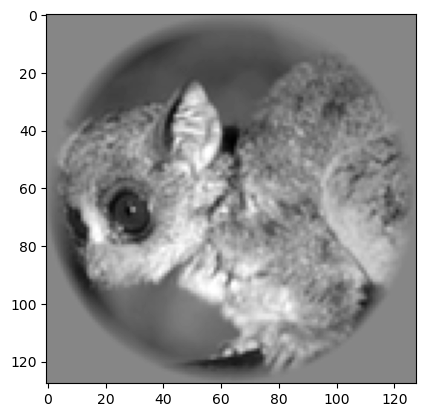

In [147]:
plt.imshow(predicted_image, cmap='gray')

In [148]:
trying_hard = pca.inverse_transform(X_test[0])
trying_hard.shape

(8428,)

In [149]:
trying = dat['responses'][predicted_image_idx]
trying.shape

(8428,)

In [141]:
dat['responses'][7].shape

(8428,)

In [140]:
trying_hard.shape

(8428,)

In [144]:
closest_index = None
closest_difference = float('inf')  # Initialize with positive infinity

for i in range(dat['responses'].shape[0]):
    difference = np.sum(np.abs(dat['responses'][i] - trying_hard))
    if difference < closest_difference:
        closest_difference = difference
        closest_index = i

print("Index with closest array:", closest_index)

Index with closest array: 1246


In [145]:
dat['responses'][1246]

array([-0.14622538, -1.94800796, -1.58334346, ...,  0.50154626,
       -1.03703687,  0.22631078])

In [146]:
trying_hard

array([-0.66828341, -0.43772112, -1.06292417, ..., -0.00795441,
       -1.22928719,  0.23105174])

In [143]:
for i in range(dat['responses'].shape[0]):
     if np.any(dat['responses'][i] == trying_hard):
        print(i)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


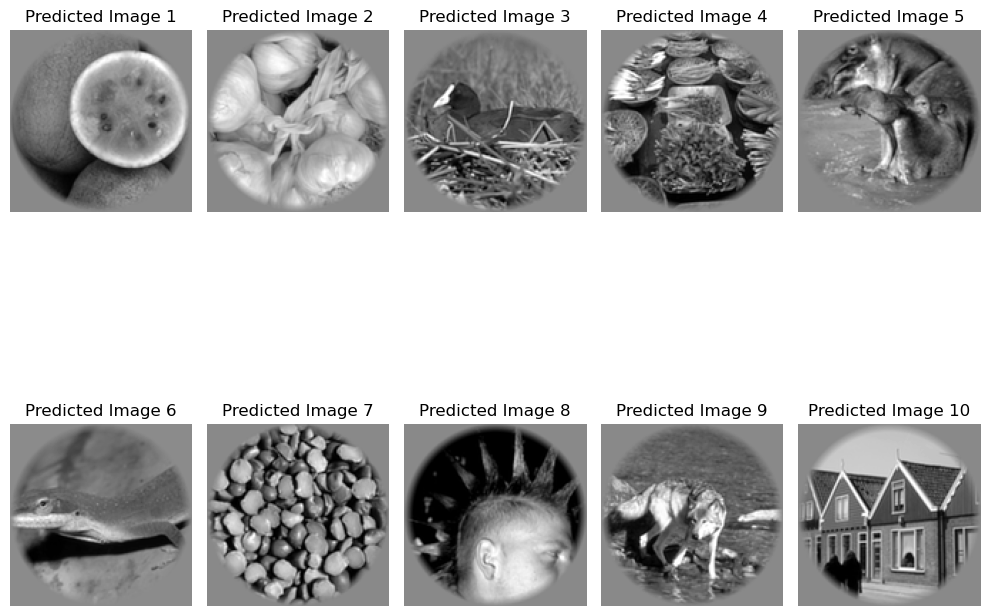

In [97]:
plt.figure(figsize=(10, 10))
for i in range(10):
    sample_response = X_test[i]
    predicted_image = predict_image(sample_response, classifier, stimuli, kmeans, scaler, pca)
    plt.subplot(2, 5, i+1)  # 2 rows, 5 columns, ith plot
    plt.imshow(predicted_image, cmap='gray')
    plt.title("Predicted Image {}".format(i+1))
    plt.axis('off')  # Turn off axis for cleaner display
plt.tight_layout()
plt.show()

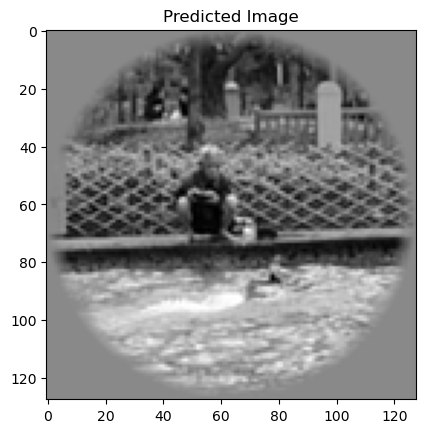

In [69]:
plt.imshow(dat['stimuli'][predicted_image_idx], cmap='gray')
plt.title("Predicted Image")
plt.show()